In [1]:
import numpy as np
import cv2
import pandas
import glob
import math
from tqdm import tqdm
from scipy.signal import triang

In [ ]:
!rm -rf /content/train
!unzip /content/drive/MyDrive/train_smol.zip -d /content

![1_06GSco3ItM3gwW2scY6Tmg[1].png](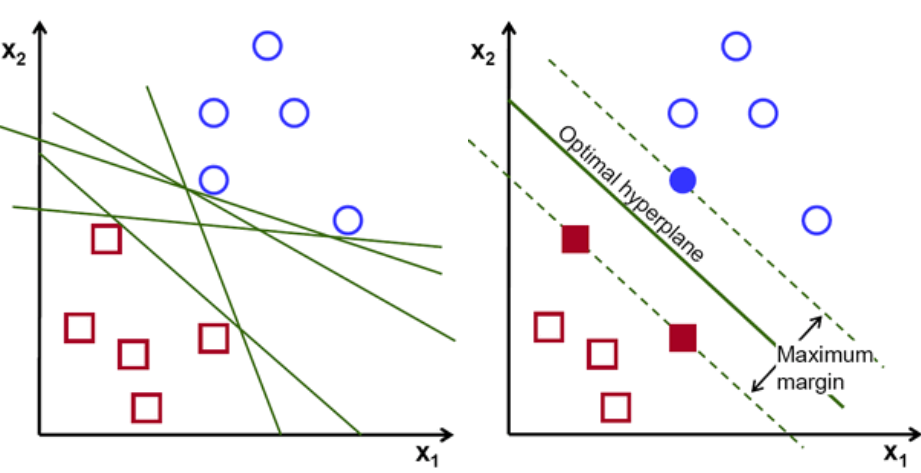)

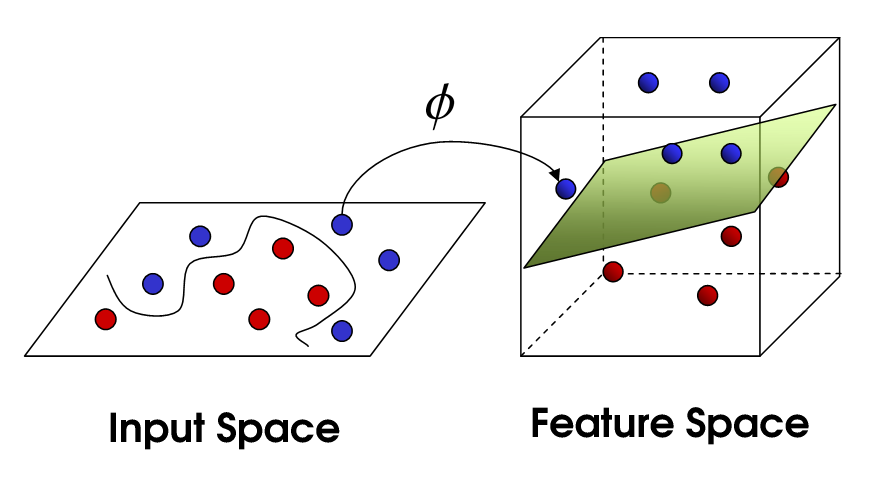

In [8]:
train_img_paths = glob.glob('train/*.jpeg')
train_img_names = [img_path.split('/')[-1].split('.')[0] for img_path in train_img_paths]
train_data = zip(train_img_paths, train_img_names)

In [9]:
df = pandas.read_csv('/content/drive/MyDrive/trainLabels.csv')
data_dict = {}
for train_img_path ,train_img_name in train_data:
  row = df.loc[df['image'] == train_img_name]
  label = row.iloc[0]['level']
  data_dict[train_img_path] = label

print(data_dict)

{'train/38097_right.jpeg': 0, 'train/6095_right.jpeg': 0, 'train/5766_left.jpeg': 2, 'train/5769_right.jpeg': 2, 'train/6088_right.jpeg': 2, 'train/5781_right.jpeg': 0, 'train/6163_left.jpeg': 2, 'train/43549_right.jpeg': 0, 'train/38113_left.jpeg': 0, 'train/5720_left.jpeg': 1, 'train/5710_right.jpeg': 0, 'train/5387_right.jpeg': 0, 'train/5387_left.jpeg': 0, 'train/5758_left.jpeg': 2, 'train/6339_left.jpeg': 2, 'train/5780_left.jpeg': 0, 'train/6093_right.jpeg': 2, 'train/6403_left.jpeg': 2, 'train/5752_right.jpeg': 0, 'train/381_right.jpeg': 0, 'train/6323_right.jpeg': 0, 'train/6125_left.jpeg': 0, 'train/6125_right.jpeg': 0, 'train/43550_right.jpeg': 0, 'train/6158_left.jpeg': 0, 'train/5740_left.jpeg': 2, 'train/6096_left.jpeg': 4, 'train/6129_right.jpeg': 2, 'train/6131_left.jpeg': 0, 'train/6342_left.jpeg': 0, 'train/38114_right.jpeg': 1, 'train/6344_left.jpeg': 0, 'train/636_left.jpeg': 0, 'train/613_right.jpeg': 0, 'train/611_right.jpeg': 0, 'train/6318_right.jpeg': 0, 'train/

In [10]:
# TODO - studenti pouziji houghovu transformaci z githubu od Petra na oriznuti
res = np.zeros((2), dtype=np.float32)
for img_path in tqdm(data_dict.keys()):
  img = cv2.imread(img_path)
  res += img.shape[:2]
avg_res = (res / len(data_dict.keys())).astype(np.int32)
print(avg_res)

100%|██████████| 272/272 [00:32<00:00,  8.41it/s]


[2490 3651]


In [16]:
factor = 3
len(data_dict.keys()) * (avg_res[0] / factor) * (avg_res[1] / factor) * 1 * 32 / 8 / 1024 / 1024 / 1024

1.023523211479187

In [26]:
train_x = np.zeros((len(data_dict.keys()), math.ceil(avg_res[0] / factor) * math.ceil(avg_res[1] / factor)), dtype=np.float32)
train_y = np.zeros(len(data_dict.keys()), dtype=np.int32)

$$
\begin{bmatrix}
x_{1,1} ... x_{1,n} \\
\ddots\\
x_{m,1} ... x_{m,n} \\
\end{bmatrix}
$$

In [27]:
# vyzkouset jiny konvolucni kernel
tr = triang(factor*2+1).reshape(factor*2+1, 1)
kernel = np.dot(tr, tr.T)
kernel /= np.sum(kernel)

In [28]:
i = 0
for img_path in tqdm(data_dict.keys()):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (avg_res[1], avg_res[0]))
  img = cv2.filter2D(img, -1, kernel)[::factor, ::factor, ...]
  # feature extraction, student muze vlozit vlastni vektor features
  train_x[i, ...] = img.flatten() / 255.0
  train_y[i] = data_dict[img_path]
  i += 1

train_y[train_y != 0] = -1
train_y[train_y == 0] = 1

100%|██████████| 272/272 [01:04<00:00,  4.21it/s]


In [29]:
# https://docs.opencv.org/3.4/d1/d73/tutorial_introduction_to_svm.html
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

In [30]:
svm.train(train_x, cv2.ml.ROW_SAMPLE, train_y)

True

In [34]:
# predikovat ne trenovaci data, ale testovaci
predictions = np.copy(train_y)
for i in tqdm(range(train_x.shape[0])):
  predictions[i] = svm.predict(train_x[i:i+1, ...])[1]

ind = predictions == train_y
print(np.sum(ind), np.sum(ind) / train_y.shape[0] * 100)

100%|██████████| 272/272 [00:00<00:00, 1314.83it/s]

113 41.544117647058826
